# 사용법

- 테스트 폴더 내에 있는 requirement.txt와 데이터의 위치를 ' /content/drive/MyDrive/TEST/ ' 로 지정해 주신후 사용하시면 됩니다!


- 테스트_데이터
    - /content/drive/MyDrive/TEST/테스트_데이터

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Sequential
from keras.layers import LSTM, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Activation, Dropout, Input, Embedding, Masking
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# System libraries
import os
import pathlib
from tqdm import tqdm
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

tf.__version__, keras.__version__

('2.11.0', '2.11.0')

In [3]:
import glob

fires = glob.glob('/content/drive/MyDrive/TEST/테스트_데이터/fire/*')
non_fires = glob.glob('/content/drive/MyDrive/TEST/테스트_데이터/non_fire/*')

In [4]:
# 데이터 프레임 만들기
data = pd.DataFrame(columns = ['Img', 'isFire'])

# 화재가 아닌 데이터
for non_fire in non_fires:
  data = data.append(pd.DataFrame([[non_fire, 0]], columns = ['Img', 'isFire']))

# 화재인 데이터  
for fire in fires:
  data = data.append(pd.DataFrame([[fire, 1]], columns = ['Img', 'isFire']))

# 인덱스 초기화
data = data.reset_index(drop = True)
data

<ipython-input-4-56409e8c24bf>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([[non_fire, 0]], columns = ['Img', 'isFire']))
<ipython-input-4-56409e8c24bf>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([[non_fire, 0]], columns = ['Img', 'isFire']))
<ipython-input-4-56409e8c24bf>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([[non_fire, 0]], columns = ['Img', 'isFire']))
<ipython-input-4-56409e8c24bf>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([[non_fire, 0]], columns = ['Img', 'isFire']))
<ipython

,Img,isFire
0,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
1,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
2,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
3,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
4,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
5,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
6,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
7,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/1...,0
8,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/2...,0
9,/content/drive/MyDrive/TEST/테스트_데이터/non_fire/3...,0


In [5]:
import cv2

# 크기 조절, 스케일링, 이미지 -> 배열 전환
def GiveImages(data):
    image_array = [] 
    class_name = []
    non_image = []
    IMG_SIZE = 256 # 표준 이미지 사이즈 ( 256 * 256 ) 설정
    
    for i in tqdm(range(data.shape[0])):
        image = cv2.imread(data.Img[i], cv2.COLOR_BGR2RGB) # BGR -> RGB 형태 변환
        try:
          image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC) # 정사각형 이미지로 설정
        except:
          non_image = i # 이미지 상 오류 발생하는 경우 있음
          continue
        image = np.array(image) # 이미지를 배열 전환
        image = image.astype('float32') # 데이터 타입 변환
        image /= 255 # 사이즈 조절
        
        image_array.append(image)
        class_name.append(data['isFire'][i])

    return np.array(image_array), np.array(class_name), non_image

X, y, non_img = GiveImages(data)
#Show the shape of X and Y
X.shape, y.shape, non_img

100%|██████████| 32/32 [00:00<00:00, 120.99it/s]


((32, 256, 256, 3), (32,), [])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25, 256, 256, 3), (7, 256, 256, 3), (25,), (7,))

In [7]:
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

NON-FIRE IMAGES ON TRAINING DATA:  13
FIRE IMAGES ON TRAINING DATA:  12


In [8]:
# 학습 변수 설정
EPOCH = 30 # 설정 : 학습
BATCH_SIZE = 16 # 설정 : 1회 학습 시 16 데이터 사용
IS_GPU = True

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
'''
  include_top = True : 불러온 신경망의 가장 마지막층(출력층)을 포함시킨다 , False 시 빼고 가져온다
  weights = 'imagenet' : imagenet -> 이미지넷으로부터 사전학습된 모델, 가중치를 그대로 사용
  input_shape = None : 원래 모델의 크기와 다른 이미지를 사용 할 것이므로 -> 새로 학습 -> 전체데이터 -> shape 변경 

'''
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
vgg16_input = vgg16.input
vgg16.tranable = False

x = Flatten()(vgg16.output)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation = 'relu')(x)
x = Dropout(0.1)(x)
vgg16_output = Dense(1, activation = 'sigmoid')(x)
vgg16_model = Model(inputs = vgg16_input, outputs = vgg16_output)
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [10]:
vgg16_model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.0001), # 최적화 도구 
    loss = 'binary_crossentropy', # 손실함수 : 값이 0에 가까울 수록 좋다 
    metrics = ['accuracy']
)

In [11]:
vgg16_callbacks = [
  # 조기학습 종료가 되고, patiemce 회수만큼 더 학습을 수행하는데 변동이 없다면 종료
  EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
  ),
  # 모델 저장, 옵션따라 조건이 달라짐. 기본값 기준 세대별 저장
  ModelCheckpoint(
    filepath='/content/drive/MyDrive/동엽/model_save/vgg16_model_{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
  ),
  # 텐서보드 로드용 데이터 저장
  TensorBoard(log_dir='./logs'),

  # Learning Rate를 조절해 모델의 개선을 유도 :  https://deep-deep-deep.tistory.com/56
  ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
]

In [12]:
vgg16_hist = vgg16_model.fit(
      X_train, 
      y_train,
      batch_size = BATCH_SIZE,
      epochs = EPOCH,
      validation_data = (X_test, y_test), # 편의상 검증용 제너레이터가 없어서 테스트용 사용 -> 과적합 방지
      callbacks = vgg16_callbacks
  )

Epoch 1/30
2/2 [==============================] - 20s 6s/step - loss: 0.6799 - accuracy: 0.5600 - val_loss: 0.6744 - val_accuracy: 0.4286 - lr: 1.0000e-04
Epoch 2/30
2/2 [==============================] - 1s 432ms/step - loss: 0.5780 - accuracy: 0.5600 - val_loss: 0.7650 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 3/30
2/2 [==============================] - 1s 296ms/step - loss: 0.4490 - accuracy: 0.7600 - val_loss: 0.5916 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 4/30
2/2 [==============================] - 1s 268ms/step - loss: 0.1783 - accuracy: 1.0000 - val_loss: 0.7589 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/30
2/2 [==============================] - 1s 426ms/step - loss: 0.0983 - accuracy: 0.9200 - val_loss: 1.4210 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 6/30
2/2 [==============================] - 1s 257ms/step - loss: 0.2496 - accuracy: 0.8800 - val_loss: 3.4359 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 7/30
2/2 [==============================] - 2s 1s/step

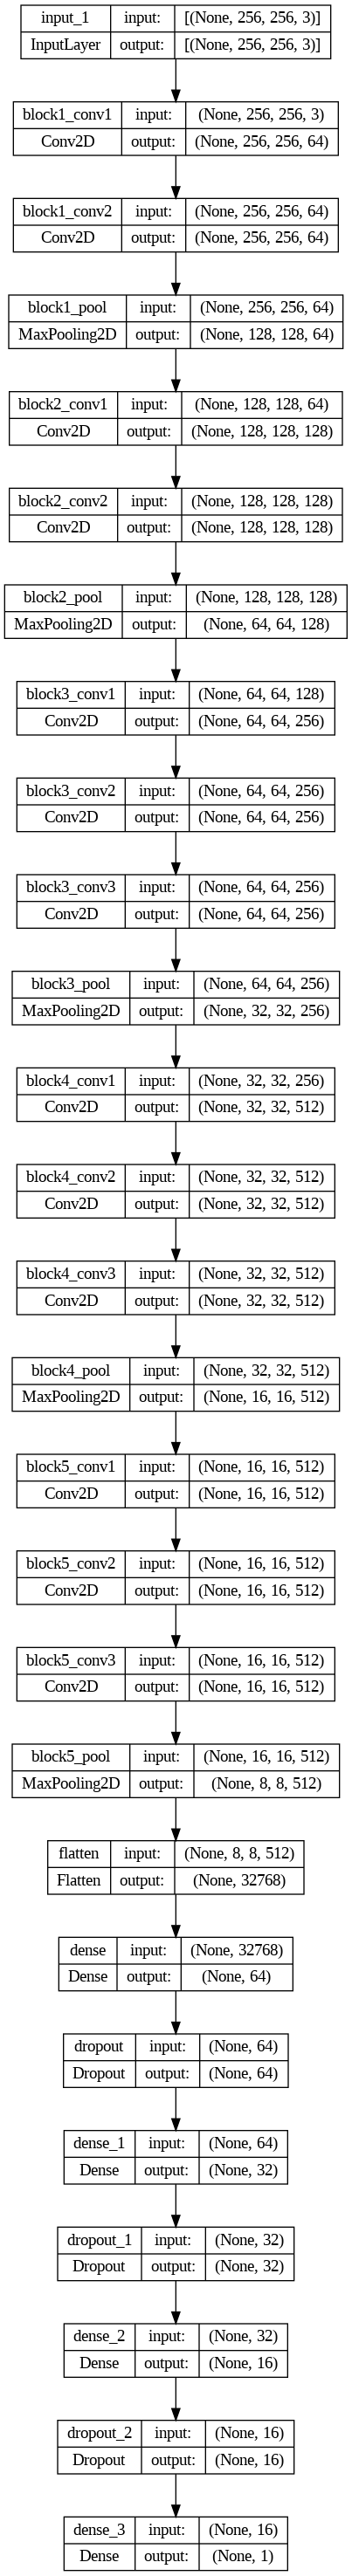

In [14]:
# 모델 정보 시각화
keras.utils.plot_model(vgg16_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [15]:
vgg16_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 105ms/step - loss: 0.1902 - accuracy: 1.0000


[0.1902078241109848, 1.0]

In [16]:
history = vgg16_hist.history

In [17]:
import plotly.express as px
px.line(history,title = "Metrics Plot")

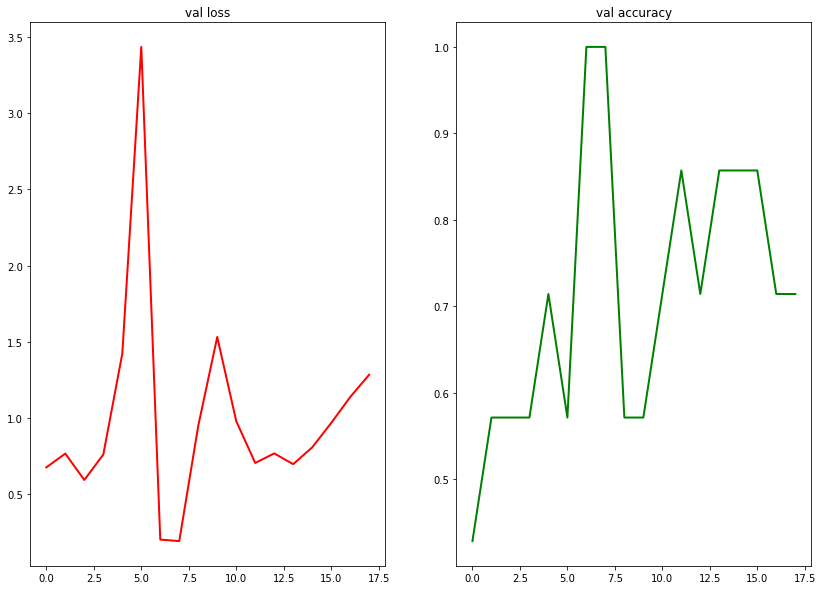

In [18]:
fig, axes = plt.subplots(1,2,figsize=(14,10))
axes[0].set_title('val loss');
axes[1].set_title('val accuracy')

axes[0].plot(history['val_loss'], color = 'red', lw=2);
axes[1].plot(history['val_accuracy'], color = 'green', lw=2);

1/1 [==============================] - 0s 183ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



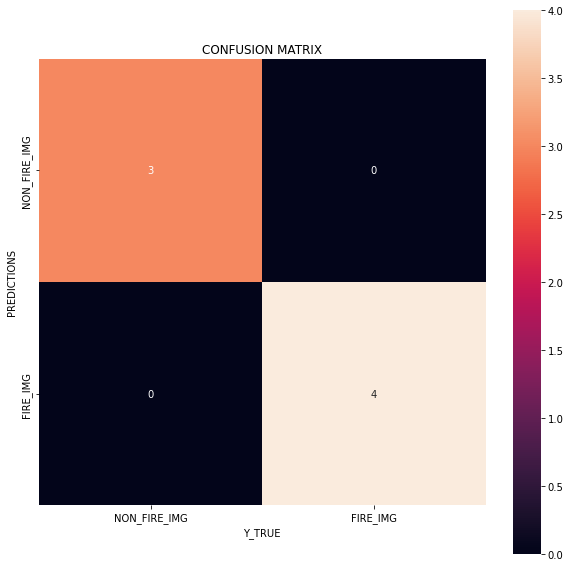

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

y_pred = (vgg16_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, 
            square=True, 
            annot=True,
            yticklabels=['NON_FIRE_IMG', 'FIRE_IMG'],
            xticklabels=['NON_FIRE_IMG', 'FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");